# Partial Report 

- David Cairuz da Silva, 10830061, davidcairuz@usp.br
- Luiza Pereira Pinto Machado, 7564426, lmach@usp.br
- Maria Fernanda Lucio de Mello, 11320860, mariafernanda.mello@usp.br
- Marina Fontes Alcantara Machado, 10692040, marina.fmachado@usp.br 

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

## Processing the Image

In [2]:
debug = True

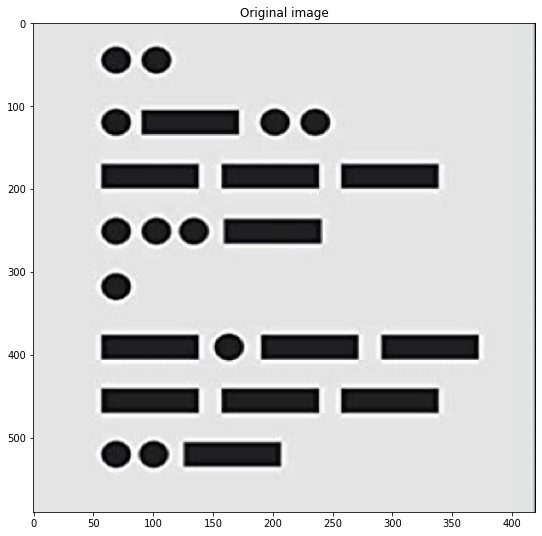

In [3]:
image = cv2.imread('input_images/digital0.jpg',)
image = cv2.resize(image, (420,590))

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(image)
ax.set_aspect('auto')
plt.title('Original image')
plt.show()

The first step is to turn the image to gray scale to prepare it for further processing

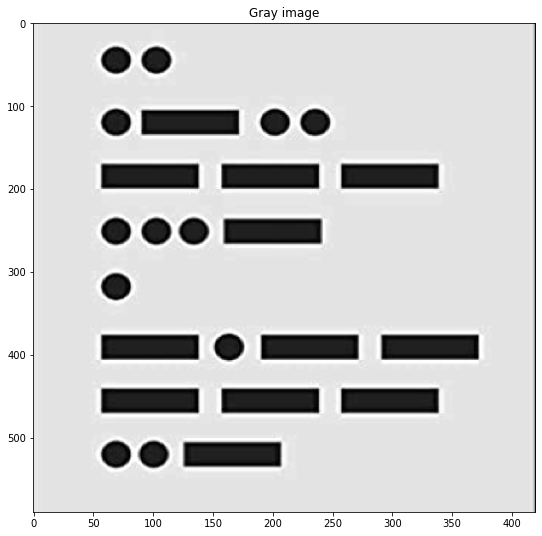

In [4]:
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(gray_image, cmap='gray')
ax.set_aspect('auto')
plt.title('Gray image')
plt.show()

Next up, the image is segmented using the adaptive thresholding technique, which considers different thresholds for different areas of the image. To decide how the threshold value is calculated, the gaussian-weighted sum of neighbourhood values is used as well as the function THRESH_BINARY_INV, which sets the max value to whatever is different from zero.

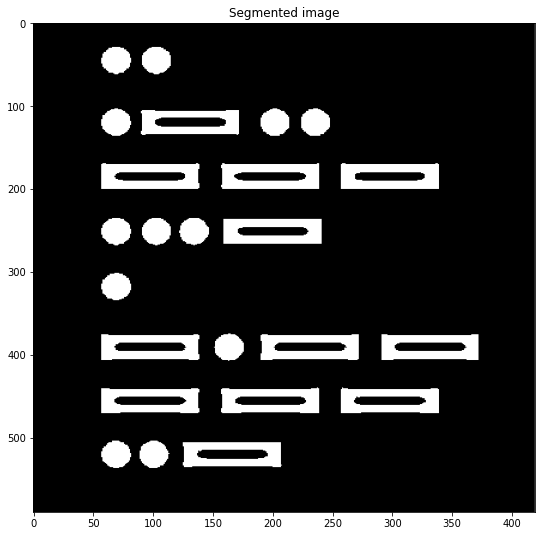

In [5]:
seg_image = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,45,15)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(seg_image, cmap='gray')
ax.set_aspect('auto')
plt.title('Segmented image')
plt.show()

The second step aims to morphologically transform the image in order to make it easier to deal with it later on. The transformation used is the opening, which consists on an erosion followed by a dilation. The erosion transformation is responsible for removing any pixels with a different color form the background that is not within the limits of the foreground object. Afterwards, the dilation transformation takes part in the process, executing the opposite of what erosion just did. It turns any pixel element into '1' if at least one pixel under the kernel is '1'. This increases the area of the foregroung object. The reason why theses two transformations are used in the specific order is that erosion removes white noises while it also shrinks the object. Dilation, then, is used to increase the object size once again.

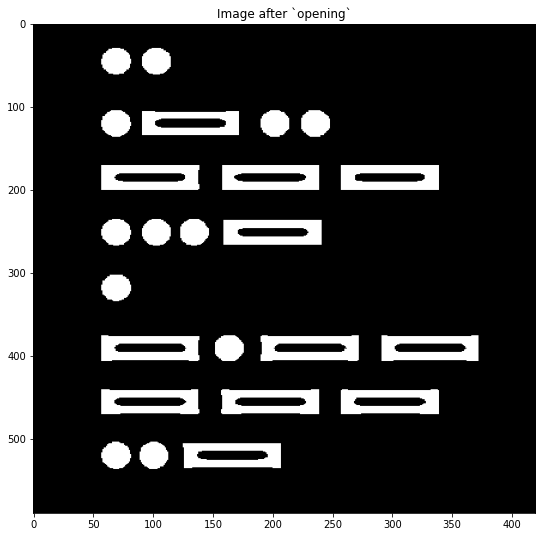

In [6]:
kernel = np.ones((5,5),np.uint8)
open_image = cv2.morphologyEx(seg_image, cv2.MORPH_OPEN, kernel)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(open_image, cmap='gray')
ax.set_aspect('auto')
plt.title('Image after `opening`')
plt.show()

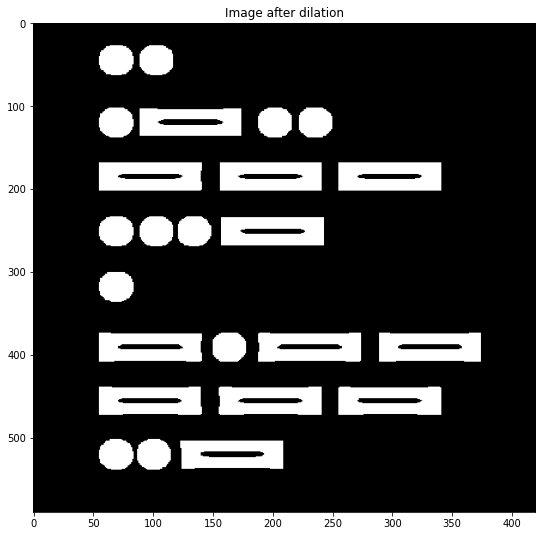

In [7]:
kernel = np.ones((5,5),np.uint8)
dilated_image = cv2.dilate(open_image,kernel,iterations = 1)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(dilated_image, cmap='gray')
ax.set_aspect('auto')
plt.title('Image after dilation')
plt.show()

In [15]:
contour = cv2.findContours(dilated_image.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[0]
copyImage = np.zeros((image.shape[0],image.shape[1],3),dtype='uint8')

In [16]:
for cnt in contour:
    approx = cv2.approxPolyDP(cnt, 0.001, True) # approximates the shape of a contour to the shape of a polygon
    hull = cv2.convexHull(approx) # creates a convex polygon based on the approximation
    
    # draws the rectangle that bounds each contour as explained in https://www.pythonpool.com/cv2-boundingrect/
    x, y, w, h = cv2.boundingRect(hull)
    cv2.rectangle(copyImage, (x,y), (x+w,y+h), (0,255,0), -1)

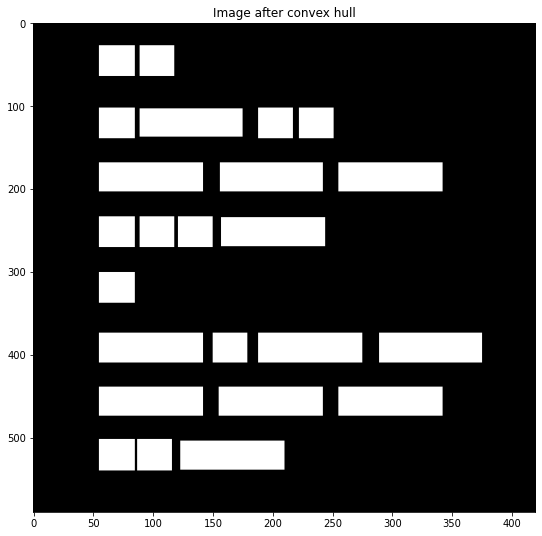

In [17]:
copyImage = copyImage[:,:,1]
image = cv2.resize(copyImage,(420,590),interpolation=cv2.INTER_CUBIC)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(image, cmap='gray')
ax.set_aspect('auto')
plt.title('Image after convex hull')
plt.show()

## From Image to Morse

Following, the image as a whole is analyzed, pixel by pixel. The differentiation between the dot and the dash is made by measuring the width of a line of white pixels which, at this point of the development of the project, was chosen as the color of contrast. The background is currently set as black. This function is not working properly yet and we believe the last step of image processing might fix it.

In [11]:
def image_to_morse(image, line_threshold=30):
    x,y = image.shape
    
    morse = []
    result = []
    coordinates_list = []

    # Walking through image pixels (verticaly)
    for i in range(x):
        black_count, white_count = 0, 0
        morse_char = ''
        start_coord = (0,0)

        # Walking through image pixels (horizontaly)
        # If colored pixels are found, depending on how many there are, 
        # text is added to the variable containing the morse code information
        for j in range(y):
            if image[i, j] == 0: 
                if white_count >= line_threshold: 
                    morse_char += '_'
                elif white_count < line_threshold and white_count >= 10: 
                    morse_char += '.'
                
                black_count += 1
                white_count = 0

            # Updating starting point
            # If no colored pixels are found, the search moves forward
            elif image[i,j] > 0:
                if start_coord == (0,0): 
                    start_coord = (i,j)
                
                black_count = 0
                white_count += 1

        # If any morse code information was found, the start coordinate is updated
        if morse_char != '':
            coordinates_list.append((start_coord[1], start_coord[0]))
            morse.append(morse_char)

            start_coord = (0,0)

        # Has some text
        elif len(morse):
            data = ''
            max_ = 0
            for i, item in enumerate(morse):
                if len(item) > max_:
                    max_ = len(item)
                    data = item
            morse = []
            result.append(data)


    return result

Finally, after the set of dots and dashes have been recognized from the image and turned into text, a simple translation is made using a input dictionary from Morse code to the Latin alphabet.

In [12]:
dict_morse_to_text = {'._':'A','_...':'B','_._.':'C','_..':'D','.':'E',
                      '.._.':'F','__.':'G','....':'H','..':'I','.___':'J',
                      '_._':'K','._..':'L','__':'M','_.':'N','___':'O',
                      '.__.':'P','__._':'Q','._.':'R','...':'S','_':'T',
                      '.._':'U','..._':'V','.__':'W','_.._':'X','_.__':'Y',
                      '__..1':'Z'}    

def decode(morse):
    output = ''
    for code in morse:
        if len(code) < 5: 
            output += dict_morse_to_text[code]

    print(f'Coded Message: {morse}')
    print(f'Decoded Message: {output}')

In [14]:
decode(image_to_morse(image, 30))

Coded Message: []
Decoded Message: 
